In [1]:
# Group 6: Amy Law, Benjamin Mann, Fuyu Wang, Weipeng Wang
# Reference: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html, https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html


In [2]:
# Import the library
import os
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.utils.data
import torchvision.transforms as transforms
import numpy as np
import torch.nn.functional as F
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
# Check the GPU
print("Is avail: ",torch.cuda.is_available())
print("Device count: ",torch.cuda.device_count())
print("curr active:", torch.cuda.current_device())
print(torch.cuda.get_device_name(0))  

device = torch.device("cuda" if (torch.cuda.is_available() and torch.cuda.device_count() > 0) else "cpu")
print("curr device",device)

Is avail:  True
Device count:  1
curr active: 0
NVIDIA A100-SXM4-40GB
curr device cuda


In [4]:
# One hot encoding for types
types = ['Bug', 'Dark', 'Dragon', 'Electric', 'Fairy', 'Fighting', 'Fire', 'Flying', 'Ghost', 'Grass', 'Ground', 'Ice', 'Normal', 'Poison', 'Psychic', 'Rock', 'Steel', 'Water']

# From 0 to 17, each number represents a type
type_dict = {}
for i in range(len(types)):
    type_dict[types[i]] = i

In [5]:
# Reference: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
# The dataset can read the csv file and images
# It could return image and its corresponding types
class MyDataSet():
    def __init__(self, csv_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # Get the path of the image
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        # Read the image and convert the format into RGB
        image = Image.open(img_path + ".png2.png").convert('RGB')
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:   
            label = self.target_transform(label)
        return image, label

In [6]:
# The Classifier architecture
# The input size is 32 x 3 x 128 x 128
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 20, kernel_size = 4, stride = 2, padding = 1, bias = False)
        self.conv2 = nn.Conv2d(20, 16, kernel_size = 4, stride = 2, padding = 1, bias = False)

        self.linear1 = nn.Linear(16 * 8 * 8, 512)
        self.linear2 = nn.Linear(512, 128)
        self.linear3 = nn.Linear(128, 64)
        self.linear4 = nn.Linear(64, 18)

        self.activation = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(p = 0.35)

    def forward(self, x):
        x = self.pool(self.activation(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(self.activation(self.conv2(x)))
        x = x.view(-1, 16 * 8 * 8)
        x = self.activation(self.linear1(x))
        x = self.activation(self.linear2(x))
        x = self.activation(self.linear3(x))
        x = self.linear4(x)
        return x

In [7]:
from google.colab import drive
drive.mount('/content/drive')

dataroot = "/content/drive/MyDrive/ecs171_data/pokemon2/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# Set up the data set
image_transform = transforms.Compose([transforms.Resize((128, 128)), 
                                        transforms.ToTensor()
                                        ])

# pokemon_dataset = MyDataSet('./pokemon.csv', './images/pokemon2/', transform = image_transform)
pokemon_dataset = MyDataSet('/content/drive/MyDrive/pokemon.csv', '/content/drive/MyDrive/ecs171_data/pokemon2/', transform = image_transform)
pokemon_dataloader = torch.utils.data.DataLoader(pokemon_dataset, batch_size=32, shuffle = True)

train_size = int(0.9 * len(pokemon_dataset))
test_size = len(pokemon_dataset) - train_size
datasetTrain, datasetTest = torch.utils.data.random_split(pokemon_dataset, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(datasetTrain, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(datasetTest, batch_size=32, shuffle=False)

In [9]:
# Number of training epochs
num_epochs = 90

# Learning rate for optimizers
lr = 1e-3

# Set up the classifier
classifier = Classifier()
classifier.cuda()

# Set up the optimizer
optimizer = torch.optim.Adam(classifier.parameters(), lr = lr)

# Loss function
loss_function = nn.CrossEntropyLoss()

In [10]:
# The function to one hot encoding the types
def OneHotEncoding(y):
    output = []
    for i in range(len(y)):
        output.append(type_dict[y[i]])

    return np.array(output)

In [11]:
# The training loop
print("curr active:", torch.cuda.current_device())
print("curr device",device)
loss = []
accuracy_values = []
for epoch in range(num_epochs):
    temp = 0
    for i, dat in enumerate(train_loader, 0):
        X, y = dat
        X.cuda()

        y = OneHotEncoding(y)
        y = torch.tensor(y).cuda()
        y = y.type(torch.LongTensor).cuda()
    
        # Zero the gradient
        classifier.zero_grad()

        # Get pred
        y_pred = classifier(X.cuda())

        # Get the evaluation value
        lossItem = loss_function(y_pred, y)
        accuracy = accuracy_score(y.cpu(), y_pred.max(1)[1].cpu().detach().numpy())
        
        # Back prop and move next image
        lossItem.backward()
        optimizer.step()

        # Print out the information for each epoch
        if i % 100 == 0:
            # Store the value for further evaluation
            loss.append(lossItem.item())
            accuracy_values.append(accuracy)

            # Print out the values
            print("epoch: ", epoch)
            print("loss", lossItem.item())
            print("accuracy: ", accuracy)

curr active: 0
curr device cuda
epoch:  0
loss 2.862523317337036
accuracy:  0.21875
epoch:  1
loss 2.7423977851867676
accuracy:  0.125
epoch:  2
loss 2.768906831741333
accuracy:  0.125
epoch:  3
loss 2.660797357559204
accuracy:  0.125
epoch:  4
loss 2.535752773284912
accuracy:  0.15625
epoch:  5
loss 2.846736192703247
accuracy:  0.03125
epoch:  6
loss 2.775496482849121
accuracy:  0.03125
epoch:  7
loss 2.663235664367676
accuracy:  0.125
epoch:  8
loss 2.448617935180664
accuracy:  0.21875
epoch:  9
loss 2.600003480911255
accuracy:  0.1875
epoch:  10
loss 2.2170801162719727
accuracy:  0.34375
epoch:  11
loss 2.543780565261841
accuracy:  0.25
epoch:  12
loss 2.4402010440826416
accuracy:  0.28125
epoch:  13
loss 1.9660156965255737
accuracy:  0.375
epoch:  14
loss 1.9406622648239136
accuracy:  0.375
epoch:  15
loss 1.8433239459991455
accuracy:  0.375
epoch:  16
loss 2.1061575412750244
accuracy:  0.28125
epoch:  17
loss 1.8461856842041016
accuracy:  0.4375
epoch:  18
loss 1.5123111009597778


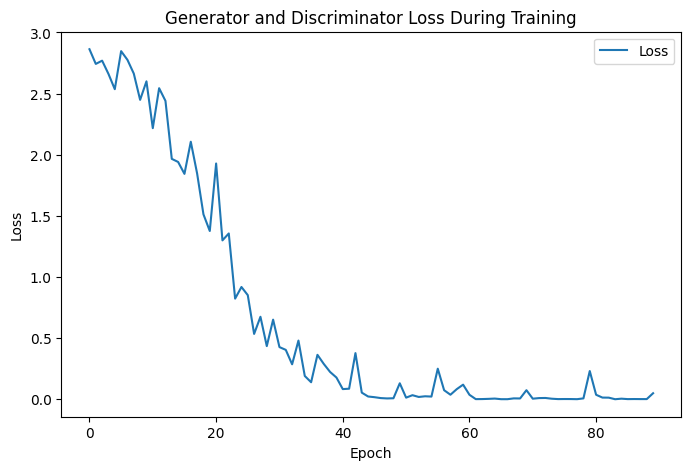

In [12]:
# Plot the model loss
plt.figure(figsize=(8,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(loss,label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

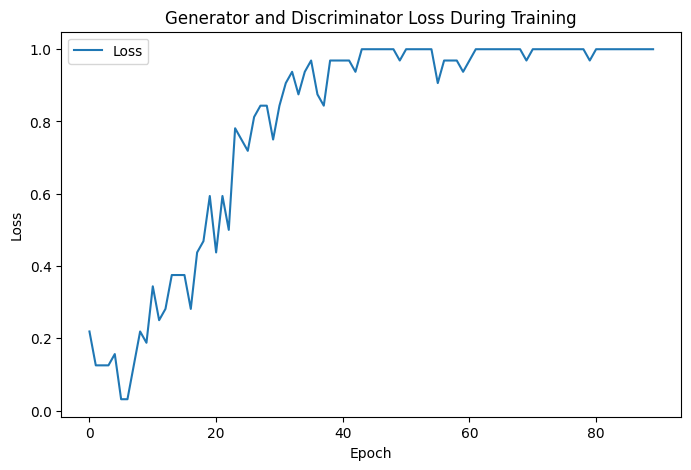

In [13]:
# Plot the model accuracy during training
plt.figure(figsize=(8,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(accuracy_values,label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [16]:
# Export the model
model_name = "pokemon_classifier.pth"
path = F"/content/drive/MyDrive/{model_name}"
torch.save(classifier.state_dict(), path)

In [15]:
correct = 0
total = 0

# Evaluate the performance of the model
with torch.no_grad():
    for data in pokemon_dataloader:
        images, labels = data
        # print(labels)
        labels = OneHotEncoding(labels)
        # print(labels)
        # print(len(labels))
        outputs = classifier(images.cuda())
        _, predicted = torch.max(outputs.data, 1)
        #print(predicted)
        for i in range(len(outputs)):
            #print(labels[i], predicted[i].detach().numpy())
            if(labels[i] == predicted[i].cpu().detach().numpy()):
                correct += 1
            total += 1

print(f'Accuracy of the network on the  test images: {100 * correct // total} %')


Accuracy of the network on the  test images: 91 %
